<a href="https://colab.research.google.com/github/TangJiahui/6.036_Machine_Learning/blob/main/MIT_6_036_HW07_PyTorch_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT 6.036 Fall 2020: Homework 7 - PyTorch

This colab notebook provides code and a framework for homework 7. You can work out your solutions here, then submit your results back on the homework page when ready.

**Note**: You can go to `File > Save a copy in Drive...` to save your own copy of this notebook for editing.

## Setup

First, download the code distribution for this homework that contains test cases and helper functions. Run the next code block to download and import the code for this lab.

In [1]:
!rm -rf code_for_hw7 data
!rm code_for_hw7.zip
!wget --no-check-certificate --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw07/code_for_hw7.zip
!unzip code_for_hw7.zip
!mv code_for_hw7/* .

rm: cannot remove 'code_for_hw7.zip': No such file or directory
Archive:  code_for_hw7.zip
   creating: code_for_hw7/
  inflating: code_for_hw7/code_for_hw7.py  
  inflating: code_for_hw7/pytorch_code_for_hw7.py  
  inflating: code_for_hw7/code_for_hw7_pytorch.py  
   creating: code_for_hw7/data/
  inflating: code_for_hw7/data/data5_validate.csv  
  inflating: code_for_hw7/data/data5_train.csv  
  inflating: code_for_hw7/data/data1_train.csv  
  inflating: code_for_hw7/data/data1_validate.csv  
  inflating: code_for_hw7/data/data2_train.csv  
  inflating: code_for_hw7/data/data2_validate.csv  
  inflating: code_for_hw7/data/data3_train.csv  
  inflating: code_for_hw7/data/data3_validate.csv  
  inflating: code_for_hw7/data/data3class_train.csv  
  inflating: code_for_hw7/data/data4_train.csv  
  inflating: code_for_hw7/data/data4_validate.csv  
  inflating: code_for_hw7/data/dataXor_train.csv  
  inflating: code_for_hw7/expected_results.py  
  inflating: code_for_hw7/modules_disp.py  


# 3) 2D Datasets

For the 2D datasets, we have provided the following function:

>```run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True, trials=5)```

where:

* `data_name` is a string, such as '1', '2', etc. 
* `layers` is a list of torch.nn layer definitions for a Sequential model, e.g.
> ```[Linear(in_features=2, out_features=classes, bias=True), Softmax(dim=-1)]```
* `epochs` is an integer indicating how many times to go through the data in training 
* `split` is a fraction of the training data to use for validation if a validation set is not defined 
* `display` whether to display result plots 
* `verbose` whether to print loss and accuracy (percent correctly labeled) each epoch 
* `trials` is an integer indicating how many times to perform the training and testing 

The two-class datasets have `data_name`s: `'1'`,`'2'`,`'3'`,`'4'`.

In this problem, try the following 5 architectures, specified by the number of units in the hidden layers:

`0: (), 1: (10), 2: (100), 3: (100, 10), 4: (100, 100)`

You may find the `archs` function below to be helpful here. Some of these questions ask for the "simplest" architecture; the list above is ordered starting with the simplest.

## Helper Functions

The following functions will train a neural network in PyTorch. You do not need to edit them but please try to go through them. There is a section below that shows how to run these methods for the homework.

In [2]:
from utils_hw7 import plot_heat, get_data_loader, model_fit, model_evaluate, run_pytorch, dataset_paths

In [3]:
import numpy as np
import itertools
import math as m
from matplotlib import pyplot as plt

In [22]:
import torch
from torch.nn import Linear, ReLU, Softmax, Sequential, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


######################################################################
# Problem 3 - 2D data
######################################################################

def archs(classes):
    # param: classes (int) determines the size of the pre-activations before they go into softmax.
    # return: (dict) a dictionary mapping integers 0-4 to architectures with increasing complexity.
    return {0: [Linear(in_features=2, out_features=classes, bias=True),
             Softmax(dim=-1)],
            
            1: [Linear(in_features=2, out_features=10, bias=True),
             ReLU(),
             Linear(in_features=10, out_features=classes, bias=True),
             Softmax(dim=-1)],

            2: [Linear(in_features=2, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=classes, bias=True),
             Softmax(dim=-1)],
            
            3: [Linear(in_features=2, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=10, bias=True),
             ReLU(),
             Linear(in_features=10, out_features=classes, bias=True),
             Softmax(dim=-1)],

            4: [Linear(in_features=2, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=classes, bias=True),
             Softmax(dim=-1)],
            
            5: [Linear(in_features=2, out_features=1, bias=True),
             ReLU(),
             Linear(in_features=1, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=classes, bias=True),
             Softmax(dim=-1)],
           }



In [19]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention.
Please try to go through it.
"""

def call_model(mode, model, data_iter, optimizer, criterion):
    epoch_loss = []
    hits = []
    items = []
    
    if mode == 'train':
        model.train()
        grad_mode = torch.enable_grad()
    else:
        model.eval()
        grad_mode = torch.no_grad()

    with grad_mode:

        for batch in data_iter:
            X, y = batch.X, batch.y

            if mode == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward
            y_hat = model(X)
            batch_loss = criterion(y_hat, y.long())

            if mode == 'train':
                # backward + optimize
                batch_loss.backward()
                optimizer.step()

            epoch_loss.append(batch_loss.item())
            hits.append((y_hat.argmax(1) == y).sum())
            items.append(X.shape[0])

        loss = np.sum(epoch_loss)/np.sum(items)
        acc_score = np.sum(hits)/np.sum(items)
        return loss, acc_score

In [20]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention because
you'll be running (but not modifying) this function for this
homework.
Please try to go through it.
"""

def run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True,
                   verbose=True, trials=1, batch_size=32):
    print('Pytorch FC: dataset=', data_name)
    (train_dataset_path, val_dataset_path, test_dataset_path) = dataset_paths(data_name)
    # Load the datasets
    train_iter, num_classes = get_data_loader(train_dataset_path, batch_size)
    val_iter, num_classes = get_data_loader(val_dataset_path, batch_size)
    test_iter, num_classes = get_data_loader(test_dataset_path, batch_size)
    
    if val_iter is None:
        # Use split
        print("Use split", train_iter)
        assert split > 0, '`split` must be > 0'
        train_iter, val_iter,  num_classes = get_data_loader(train_dataset_path, batch_size, split)

    val_acc, test_acc = 0, 0
    X_train = torch.cat([batch.X for batch in train_iter], 0)
    y_train = torch.cat([batch.y for batch in train_iter], 0)
    
    for trial in range(trials):
        trial_history = {'epoch_loss': [], 'epoch_val_loss': [],
               'epoch_acc': [], 'epoch_val_acc': []}
    
        if verbose: print("\n")
        print(f'# Trial {trial}')
        
        # Run the model
        model, vacc, tacc, = run_pytorch(train_iter, val_iter, test_iter, 
                                         layers, epochs, split=split,
                                         verbose=verbose, history=trial_history)

        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
        if display:
            # plot classifier landscape on training data
            plot_heat(X_train, y_train, model)
            plt.title('Training data')
            plt.show()
            if test_iter is not None:
                # plot classifier landscape on testing data
                X_test = torch.cat([batch.X for batch in test_iter], 0)
                y_test = torch.cat([batch.y for batch in test_iter], 0)
                plot_heat(X_test, y_test, model)
                plt.title('Testing data')
                plt.show()
            # Plot epoch loss
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_loss'], label='epoch_train_loss')
            plt.plot(range(epochs), trial_history['epoch_val_loss'], label='epoch_val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Epoch val_loss and loss')
            plt.legend()
            plt.show()
            # Plot epoch accuracy
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_acc'], label='epoch_train_acc')
            plt.plot(range(epochs), trial_history['epoch_val_acc'], label='epoch_val_acc')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.title('Epoch val_acc and acc')
            plt.show()
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))
        
   
    return X_train, y_train, model

##3A)
Here are some examples of how you can run the pytorch functions.

Pytorch FC: dataset= 3
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.02032 acc 0.71 | VALI: loss 0.01895 acc 0.955
epoch: 1 | TRAIN: loss 0.01537 acc 0.975 | VALI: loss 0.01491 acc 0.955
epoch: 2 | TRAIN: loss 0.0125 acc 0.9675 | VALI: loss 0.01326 acc 0.95
epoch: 3 | TRAIN: loss 0.01152 acc 0.975 | VALI: loss 0.01275 acc 0.965
epoch: 4 | TRAIN: loss 0.0112 acc 0.98 | VALI: loss 0.01255 acc 0.97
epoch: 5 | TRAIN: loss 0.01105 acc 0.98 | VALI: loss 0.01244 acc 0.97
epoch: 6 | TRAIN: loss 0.01097 acc 0.9825 | VALI: loss 0.01237 acc 0.97
epoch: 7 | TRAIN: loss 0.01092 acc 0.9825 | VALI: loss 0.01231 acc 0.975
epoch: 8 | TRAIN: loss 0.01088 acc 0.985 | VALI: loss 0.01226 acc 0.975
epoch: 9 | TRAIN: loss 0.01085 acc 0.985 | VALI: loss 0.01222 acc 0.975



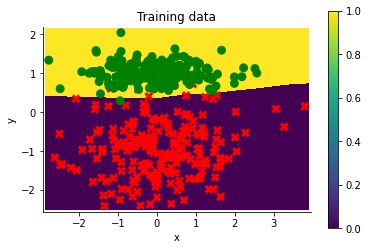

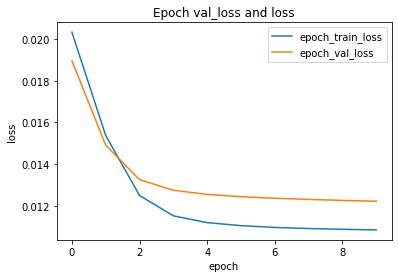

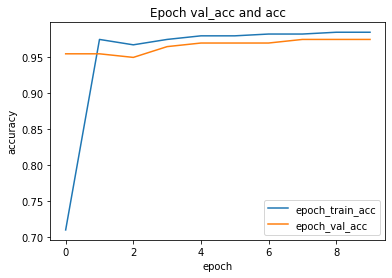


Avg. validation accuracy:0.966


In [13]:
layer_dict = archs(2) # implies we have 2 classification classes
layers = layer_dict[4] # using architecture 0

# this will train on dataset "1"
X_train, y_train, model = run_pytorch_2d("3", layers, epochs=10, trials = 1, verbose=True, display=True)

In [18]:
# if you don't care about the return values, throw them into a trash variable
for i in range(5):
    _ = run_pytorch_2d("3",archs(2)[i], epochs = 10, split=.25, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.5174500000000002
Pytorch FC: dataset= 3
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.71635
Pytorch FC: dataset= 3
Convert from -1,1 to 0,1
Loading X torch.Size([400, 

## 3B)

Pytorch FC: dataset= 3
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.02164 acc 0.7275 | VALI: loss 0.02243 acc 0.79
epoch: 1 | TRAIN: loss 0.02001 acc 0.78 | VALI: loss 0.02111 acc 0.83
epoch: 2 | TRAIN: loss 0.01889 acc 0.82 | VALI: loss 0.0199 acc 0.845
epoch: 3 | TRAIN: loss 0.01786 acc 0.8525 | VALI: loss 0.01881 acc 0.88
epoch: 4 | TRAIN: loss 0.01693 acc 0.8625 | VALI: loss 0.01788 acc 0.885
epoch: 5 | TRAIN: loss 0.01613 acc 0.8825 | VALI: loss 0.0171 acc 0.89
epoch: 6 | TRAIN: loss 0.01544 acc 0.895 | VALI: loss 0.01645 acc 0.89
epoch: 7 | TRAIN: loss 0.01485 acc 0.9125 | VALI: loss 0.01591 acc 0.905
epoch: 8 | TRAIN: loss 0.01434 acc 0.9275 | VALI: loss 0.01546 acc 0.915
epoch: 9 | TRAIN: loss 0.01391 acc 0.9325 | VALI: loss 0.01508 acc 0.915



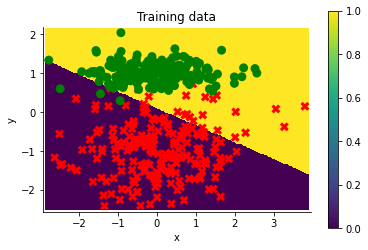

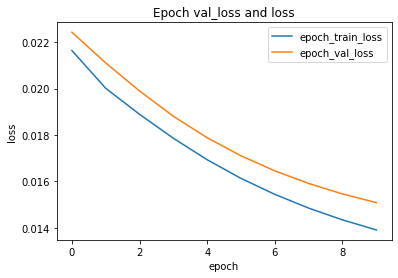

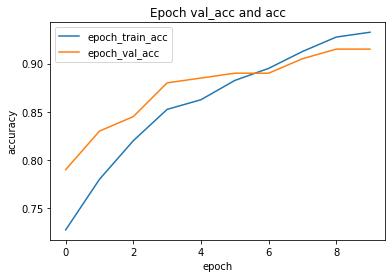



# Trial 1
epoch: 0 | TRAIN: loss 0.02238 acc 0.4925 | VALI: loss 0.02384 acc 0.595
epoch: 1 | TRAIN: loss 0.0218 acc 0.6475 | VALI: loss 0.0236 acc 0.57
epoch: 2 | TRAIN: loss 0.02143 acc 0.64 | VALI: loss 0.02337 acc 0.575
epoch: 3 | TRAIN: loss 0.02108 acc 0.6525 | VALI: loss 0.02307 acc 0.62
epoch: 4 | TRAIN: loss 0.02072 acc 0.6575 | VALI: loss 0.02276 acc 0.625
epoch: 5 | TRAIN: loss 0.02034 acc 0.675 | VALI: loss 0.0224 acc 0.645
epoch: 6 | TRAIN: loss 0.01994 acc 0.6825 | VALI: loss 0.02199 acc 0.66
epoch: 7 | TRAIN: loss 0.01951 acc 0.695 | VALI: loss 0.02152 acc 0.68
epoch: 8 | TRAIN: loss 0.01907 acc 0.7175 | VALI: loss 0.02099 acc 0.715
epoch: 9 | TRAIN: loss 0.0186 acc 0.735 | VALI: loss 0.02043 acc 0.725



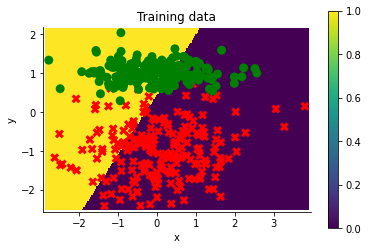

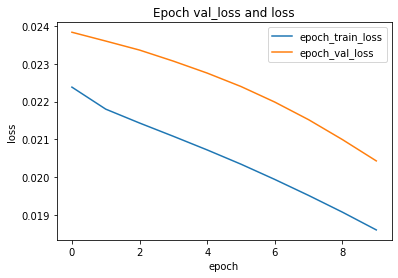

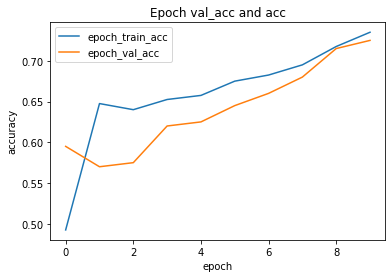



# Trial 2
epoch: 0 | TRAIN: loss 0.02193 acc 0.48 | VALI: loss 0.02245 acc 0.505
epoch: 1 | TRAIN: loss 0.02043 acc 0.7075 | VALI: loss 0.02098 acc 0.88
epoch: 2 | TRAIN: loss 0.01908 acc 0.8775 | VALI: loss 0.01967 acc 0.88
epoch: 3 | TRAIN: loss 0.01786 acc 0.8925 | VALI: loss 0.01851 acc 0.89
epoch: 4 | TRAIN: loss 0.01679 acc 0.9025 | VALI: loss 0.01752 acc 0.895
epoch: 5 | TRAIN: loss 0.01587 acc 0.9125 | VALI: loss 0.01671 acc 0.905
epoch: 6 | TRAIN: loss 0.0151 acc 0.92 | VALI: loss 0.01605 acc 0.915
epoch: 7 | TRAIN: loss 0.01447 acc 0.925 | VALI: loss 0.01553 acc 0.92
epoch: 8 | TRAIN: loss 0.01394 acc 0.9375 | VALI: loss 0.01512 acc 0.92
epoch: 9 | TRAIN: loss 0.01352 acc 0.9425 | VALI: loss 0.01479 acc 0.92



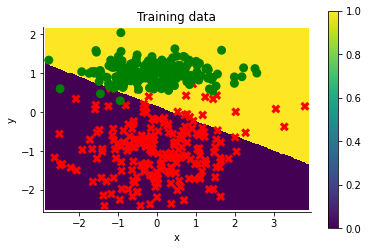

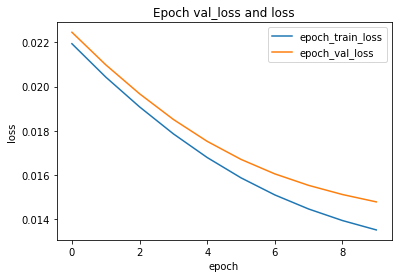

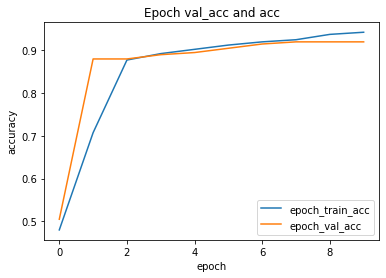



# Trial 3
epoch: 0 | TRAIN: loss 0.02251 acc 0.52 | VALI: loss 0.02426 acc 0.495
epoch: 1 | TRAIN: loss 0.02244 acc 0.52 | VALI: loss 0.02426 acc 0.495
epoch: 2 | TRAIN: loss 0.0224 acc 0.52 | VALI: loss 0.02424 acc 0.495
epoch: 3 | TRAIN: loss 0.02237 acc 0.52 | VALI: loss 0.0242 acc 0.495
epoch: 4 | TRAIN: loss 0.02232 acc 0.52 | VALI: loss 0.02413 acc 0.495
epoch: 5 | TRAIN: loss 0.02225 acc 0.52 | VALI: loss 0.02405 acc 0.495
epoch: 6 | TRAIN: loss 0.02215 acc 0.52 | VALI: loss 0.02393 acc 0.495
epoch: 7 | TRAIN: loss 0.02203 acc 0.52 | VALI: loss 0.0238 acc 0.495
epoch: 8 | TRAIN: loss 0.02189 acc 0.52 | VALI: loss 0.02363 acc 0.495
epoch: 9 | TRAIN: loss 0.02172 acc 0.495 | VALI: loss 0.02344 acc 0.625



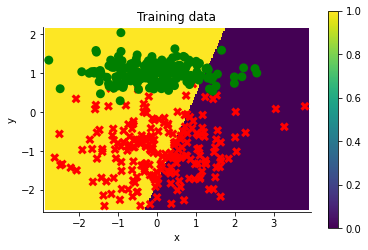

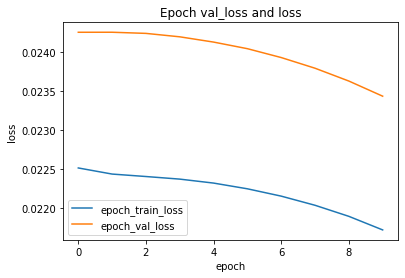

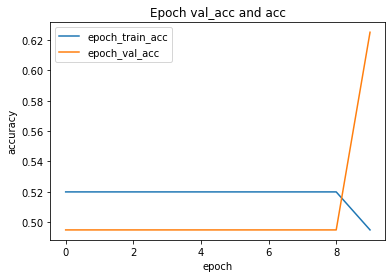



# Trial 4
epoch: 0 | TRAIN: loss 0.0223 acc 0.57 | VALI: loss 0.02392 acc 0.61
epoch: 1 | TRAIN: loss 0.02202 acc 0.555 | VALI: loss 0.02377 acc 0.495
epoch: 2 | TRAIN: loss 0.02184 acc 0.52 | VALI: loss 0.0236 acc 0.495
epoch: 3 | TRAIN: loss 0.02167 acc 0.53 | VALI: loss 0.02341 acc 0.615
epoch: 4 | TRAIN: loss 0.02148 acc 0.6525 | VALI: loss 0.02322 acc 0.625
epoch: 5 | TRAIN: loss 0.02128 acc 0.66 | VALI: loss 0.02302 acc 0.63
epoch: 6 | TRAIN: loss 0.02108 acc 0.67 | VALI: loss 0.02282 acc 0.64
epoch: 7 | TRAIN: loss 0.02088 acc 0.675 | VALI: loss 0.02262 acc 0.65
epoch: 8 | TRAIN: loss 0.02069 acc 0.6775 | VALI: loss 0.0224 acc 0.66
epoch: 9 | TRAIN: loss 0.02049 acc 0.6825 | VALI: loss 0.02216 acc 0.67



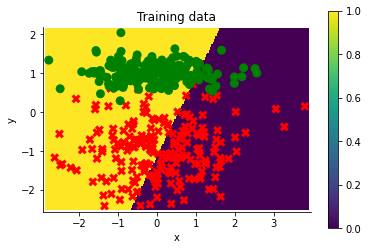

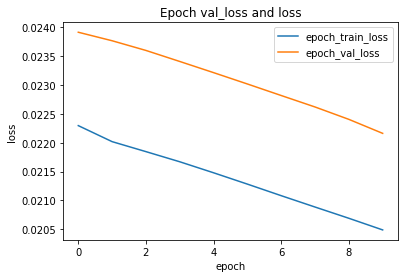

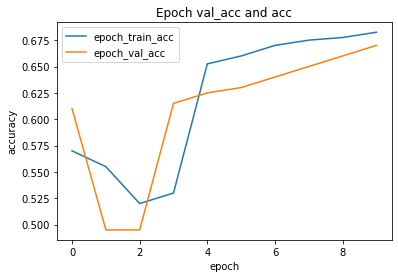



# Trial 5
epoch: 0 | TRAIN: loss 0.02277 acc 0.48 | VALI: loss 0.02421 acc 0.505
epoch: 1 | TRAIN: loss 0.02237 acc 0.5625 | VALI: loss 0.02421 acc 0.51
epoch: 2 | TRAIN: loss 0.02231 acc 0.5325 | VALI: loss 0.02417 acc 0.51
epoch: 3 | TRAIN: loss 0.02221 acc 0.545 | VALI: loss 0.024 acc 0.55
epoch: 4 | TRAIN: loss 0.022 acc 0.61 | VALI: loss 0.02376 acc 0.62
epoch: 5 | TRAIN: loss 0.02168 acc 0.665 | VALI: loss 0.02339 acc 0.665
epoch: 6 | TRAIN: loss 0.02121 acc 0.715 | VALI: loss 0.02287 acc 0.69
epoch: 7 | TRAIN: loss 0.02057 acc 0.745 | VALI: loss 0.02219 acc 0.72
epoch: 8 | TRAIN: loss 0.01979 acc 0.775 | VALI: loss 0.02141 acc 0.755
epoch: 9 | TRAIN: loss 0.01892 acc 0.815 | VALI: loss 0.02055 acc 0.78



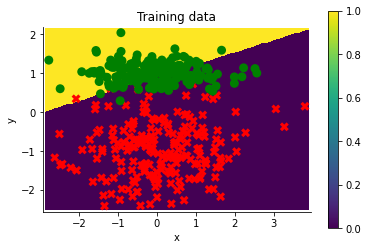

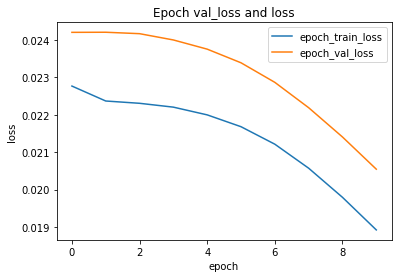

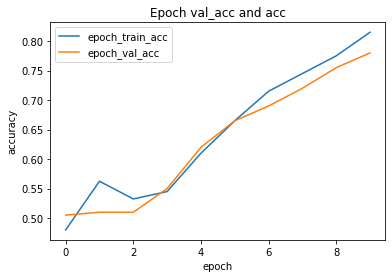



# Trial 6
epoch: 0 | TRAIN: loss 0.02261 acc 0.52 | VALI: loss 0.02374 acc 0.51
epoch: 1 | TRAIN: loss 0.02139 acc 0.675 | VALI: loss 0.02243 acc 0.82
epoch: 2 | TRAIN: loss 0.02019 acc 0.8725 | VALI: loss 0.02115 acc 0.925
epoch: 3 | TRAIN: loss 0.01897 acc 0.905 | VALI: loss 0.01989 acc 0.935
epoch: 4 | TRAIN: loss 0.01776 acc 0.94 | VALI: loss 0.01866 acc 0.94
epoch: 5 | TRAIN: loss 0.01657 acc 0.945 | VALI: loss 0.0175 acc 0.945
epoch: 6 | TRAIN: loss 0.01547 acc 0.9525 | VALI: loss 0.01646 acc 0.94
epoch: 7 | TRAIN: loss 0.01449 acc 0.9625 | VALI: loss 0.01559 acc 0.94
epoch: 8 | TRAIN: loss 0.01368 acc 0.9675 | VALI: loss 0.01489 acc 0.94
epoch: 9 | TRAIN: loss 0.01305 acc 0.97 | VALI: loss 0.01434 acc 0.935



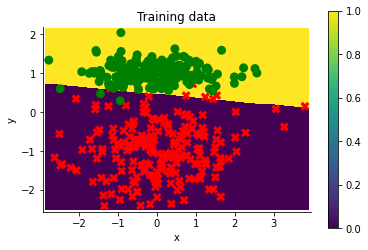

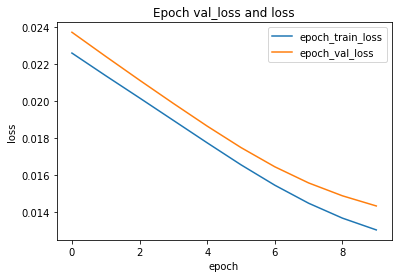

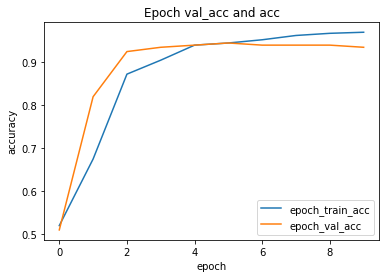



# Trial 7
epoch: 0 | TRAIN: loss 0.02253 acc 0.52 | VALI: loss 0.02423 acc 0.495
epoch: 1 | TRAIN: loss 0.0224 acc 0.52 | VALI: loss 0.02417 acc 0.495
epoch: 2 | TRAIN: loss 0.02231 acc 0.52 | VALI: loss 0.02406 acc 0.495
epoch: 3 | TRAIN: loss 0.02218 acc 0.52 | VALI: loss 0.02385 acc 0.495
epoch: 4 | TRAIN: loss 0.02197 acc 0.575 | VALI: loss 0.02354 acc 0.65
epoch: 5 | TRAIN: loss 0.02167 acc 0.5975 | VALI: loss 0.02313 acc 0.68
epoch: 6 | TRAIN: loss 0.02126 acc 0.645 | VALI: loss 0.02259 acc 0.715
epoch: 7 | TRAIN: loss 0.02073 acc 0.68 | VALI: loss 0.02191 acc 0.745
epoch: 8 | TRAIN: loss 0.02005 acc 0.71 | VALI: loss 0.02108 acc 0.78
epoch: 9 | TRAIN: loss 0.01923 acc 0.7525 | VALI: loss 0.02012 acc 0.815



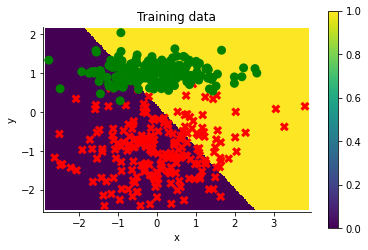

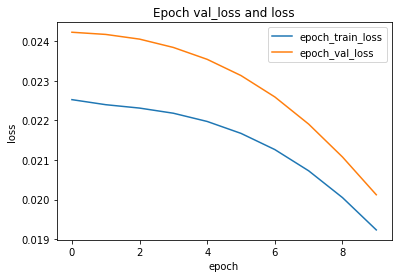

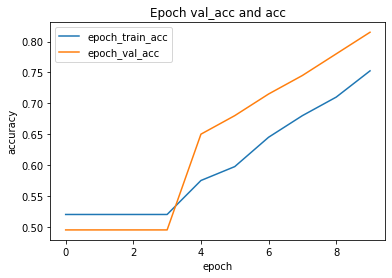



# Trial 8
epoch: 0 | TRAIN: loss 0.02283 acc 0.48 | VALI: loss 0.02369 acc 0.505
epoch: 1 | TRAIN: loss 0.02181 acc 0.54 | VALI: loss 0.02275 acc 0.815
epoch: 2 | TRAIN: loss 0.021 acc 0.7675 | VALI: loss 0.02192 acc 0.78
epoch: 3 | TRAIN: loss 0.0203 acc 0.7575 | VALI: loss 0.02111 acc 0.785
epoch: 4 | TRAIN: loss 0.01963 acc 0.7675 | VALI: loss 0.02035 acc 0.79
epoch: 5 | TRAIN: loss 0.01898 acc 0.78 | VALI: loss 0.01965 acc 0.825
epoch: 6 | TRAIN: loss 0.01835 acc 0.79 | VALI: loss 0.01898 acc 0.845
epoch: 7 | TRAIN: loss 0.01773 acc 0.8075 | VALI: loss 0.01836 acc 0.84
epoch: 8 | TRAIN: loss 0.01713 acc 0.8275 | VALI: loss 0.01779 acc 0.85
epoch: 9 | TRAIN: loss 0.01654 acc 0.85 | VALI: loss 0.01726 acc 0.865



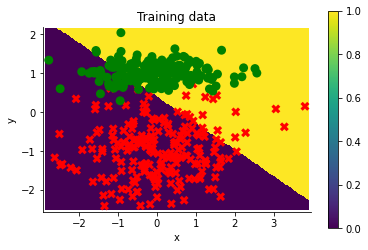

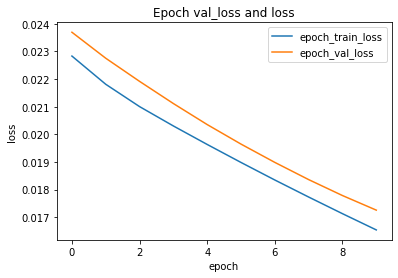

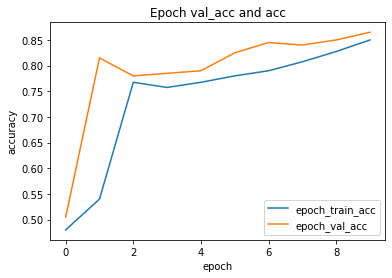



# Trial 9
epoch: 0 | TRAIN: loss 0.02322 acc 0.325 | VALI: loss 0.02459 acc 0.465
epoch: 1 | TRAIN: loss 0.02243 acc 0.515 | VALI: loss 0.0239 acc 0.495
epoch: 2 | TRAIN: loss 0.0218 acc 0.52 | VALI: loss 0.02326 acc 0.495
epoch: 3 | TRAIN: loss 0.02117 acc 0.52 | VALI: loss 0.02253 acc 0.495
epoch: 4 | TRAIN: loss 0.02045 acc 0.8475 | VALI: loss 0.02171 acc 0.885
epoch: 5 | TRAIN: loss 0.01967 acc 0.89 | VALI: loss 0.02083 acc 0.885
epoch: 6 | TRAIN: loss 0.01886 acc 0.885 | VALI: loss 0.01994 acc 0.88
epoch: 7 | TRAIN: loss 0.01804 acc 0.885 | VALI: loss 0.01909 acc 0.885
epoch: 8 | TRAIN: loss 0.01727 acc 0.8875 | VALI: loss 0.01831 acc 0.885
epoch: 9 | TRAIN: loss 0.01656 acc 0.89 | VALI: loss 0.01763 acc 0.885



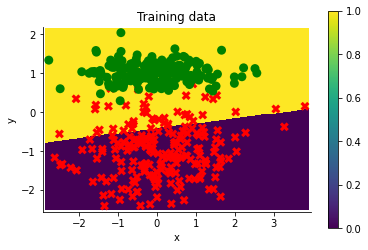

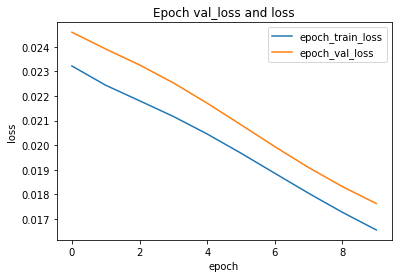

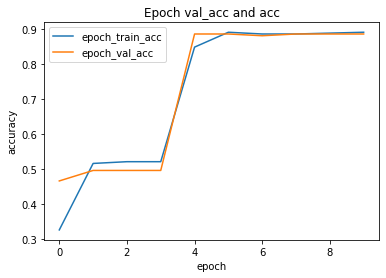



# Trial 10
epoch: 0 | TRAIN: loss 0.02277 acc 0.52 | VALI: loss 0.02434 acc 0.495
epoch: 1 | TRAIN: loss 0.0224 acc 0.535 | VALI: loss 0.02408 acc 0.53
epoch: 2 | TRAIN: loss 0.0221 acc 0.6125 | VALI: loss 0.02384 acc 0.58
epoch: 3 | TRAIN: loss 0.02178 acc 0.65 | VALI: loss 0.02358 acc 0.59
epoch: 4 | TRAIN: loss 0.02143 acc 0.665 | VALI: loss 0.0233 acc 0.595
epoch: 5 | TRAIN: loss 0.02106 acc 0.6825 | VALI: loss 0.02298 acc 0.62
epoch: 6 | TRAIN: loss 0.02066 acc 0.6875 | VALI: loss 0.02263 acc 0.64
epoch: 7 | TRAIN: loss 0.02024 acc 0.7025 | VALI: loss 0.02224 acc 0.65
epoch: 8 | TRAIN: loss 0.01979 acc 0.715 | VALI: loss 0.02179 acc 0.675
epoch: 9 | TRAIN: loss 0.01929 acc 0.7325 | VALI: loss 0.02125 acc 0.69



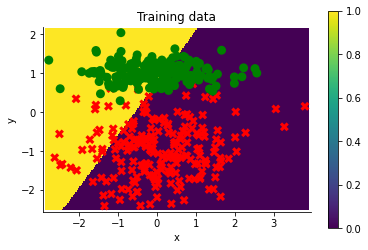

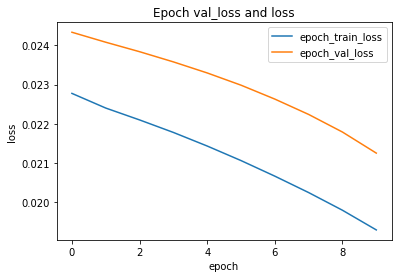

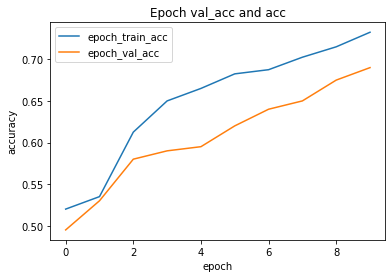



# Trial 11
epoch: 0 | TRAIN: loss 0.02253 acc 0.525 | VALI: loss 0.02425 acc 0.51
epoch: 1 | TRAIN: loss 0.02244 acc 0.5275 | VALI: loss 0.02423 acc 0.51
epoch: 2 | TRAIN: loss 0.0224 acc 0.5275 | VALI: loss 0.02418 acc 0.52
epoch: 3 | TRAIN: loss 0.02235 acc 0.5425 | VALI: loss 0.02411 acc 0.545
epoch: 4 | TRAIN: loss 0.02228 acc 0.56 | VALI: loss 0.024 acc 0.55
epoch: 5 | TRAIN: loss 0.0222 acc 0.5725 | VALI: loss 0.02388 acc 0.565
epoch: 6 | TRAIN: loss 0.0221 acc 0.5925 | VALI: loss 0.02373 acc 0.595
epoch: 7 | TRAIN: loss 0.02198 acc 0.6125 | VALI: loss 0.02355 acc 0.605
epoch: 8 | TRAIN: loss 0.02183 acc 0.62 | VALI: loss 0.02334 acc 0.63
epoch: 9 | TRAIN: loss 0.02166 acc 0.6375 | VALI: loss 0.02309 acc 0.645



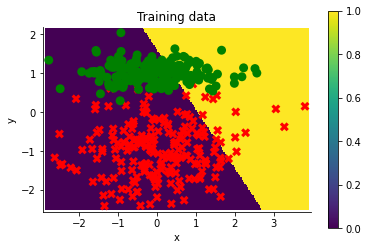

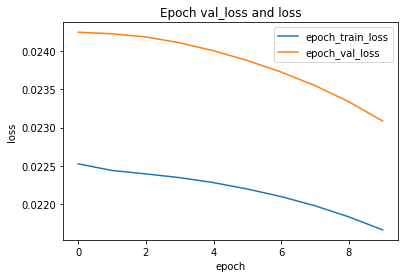

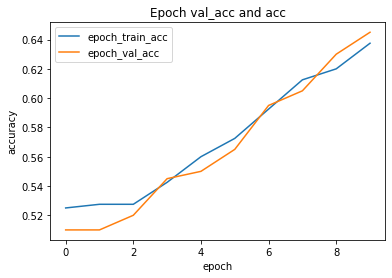



# Trial 12
epoch: 0 | TRAIN: loss 0.02163 acc 0.5725 | VALI: loss 0.02305 acc 0.8
epoch: 1 | TRAIN: loss 0.02093 acc 0.8175 | VALI: loss 0.02237 acc 0.805
epoch: 2 | TRAIN: loss 0.02029 acc 0.8175 | VALI: loss 0.02168 acc 0.805
epoch: 3 | TRAIN: loss 0.01966 acc 0.82 | VALI: loss 0.02097 acc 0.81
epoch: 4 | TRAIN: loss 0.01902 acc 0.82 | VALI: loss 0.02025 acc 0.815
epoch: 5 | TRAIN: loss 0.01838 acc 0.82 | VALI: loss 0.01953 acc 0.835
epoch: 6 | TRAIN: loss 0.01777 acc 0.8375 | VALI: loss 0.01883 acc 0.84
epoch: 7 | TRAIN: loss 0.01719 acc 0.8475 | VALI: loss 0.01818 acc 0.865
epoch: 8 | TRAIN: loss 0.01664 acc 0.8525 | VALI: loss 0.01757 acc 0.88
epoch: 9 | TRAIN: loss 0.01614 acc 0.8575 | VALI: loss 0.01702 acc 0.885



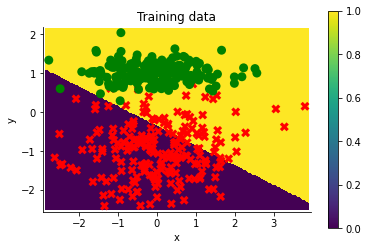

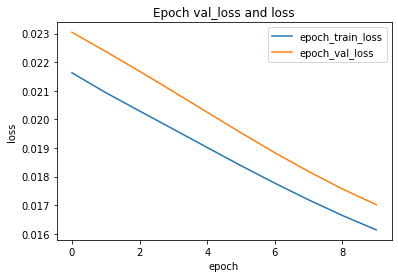

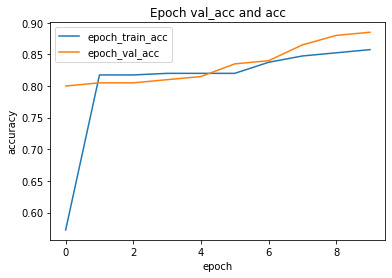



# Trial 13
epoch: 0 | TRAIN: loss 0.01916 acc 0.93 | VALI: loss 0.02003 acc 0.905
epoch: 1 | TRAIN: loss 0.01757 acc 0.935 | VALI: loss 0.01865 acc 0.925
epoch: 2 | TRAIN: loss 0.01635 acc 0.945 | VALI: loss 0.01748 acc 0.92
epoch: 3 | TRAIN: loss 0.01534 acc 0.9525 | VALI: loss 0.01656 acc 0.91
epoch: 4 | TRAIN: loss 0.01454 acc 0.95 | VALI: loss 0.01586 acc 0.91
epoch: 5 | TRAIN: loss 0.01391 acc 0.955 | VALI: loss 0.01532 acc 0.92
epoch: 6 | TRAIN: loss 0.01342 acc 0.9575 | VALI: loss 0.01488 acc 0.925
epoch: 7 | TRAIN: loss 0.01303 acc 0.9625 | VALI: loss 0.01453 acc 0.93
epoch: 8 | TRAIN: loss 0.01271 acc 0.9625 | VALI: loss 0.01424 acc 0.94
epoch: 9 | TRAIN: loss 0.01246 acc 0.9675 | VALI: loss 0.01401 acc 0.94



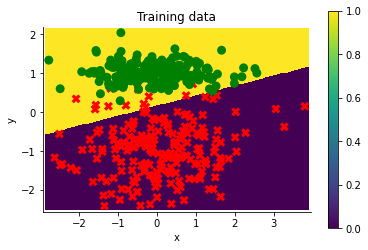

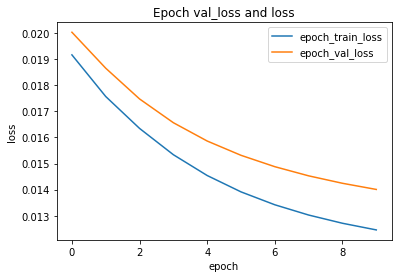

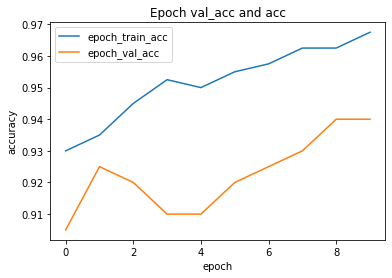



# Trial 14
epoch: 0 | TRAIN: loss 0.02228 acc 0.5275 | VALI: loss 0.02388 acc 0.55
epoch: 1 | TRAIN: loss 0.02192 acc 0.6375 | VALI: loss 0.02349 acc 0.67
epoch: 2 | TRAIN: loss 0.02149 acc 0.7275 | VALI: loss 0.02297 acc 0.735
epoch: 3 | TRAIN: loss 0.02092 acc 0.7675 | VALI: loss 0.02227 acc 0.775
epoch: 4 | TRAIN: loss 0.02018 acc 0.8125 | VALI: loss 0.02139 acc 0.82
epoch: 5 | TRAIN: loss 0.01927 acc 0.8325 | VALI: loss 0.02038 acc 0.84
epoch: 6 | TRAIN: loss 0.01821 acc 0.86 | VALI: loss 0.01928 acc 0.86
epoch: 7 | TRAIN: loss 0.01708 acc 0.8925 | VALI: loss 0.01818 acc 0.87
epoch: 8 | TRAIN: loss 0.01593 acc 0.93 | VALI: loss 0.01719 acc 0.91
epoch: 9 | TRAIN: loss 0.01488 acc 0.9425 | VALI: loss 0.0163 acc 0.925



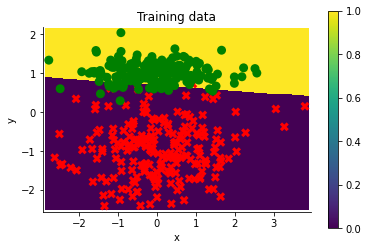

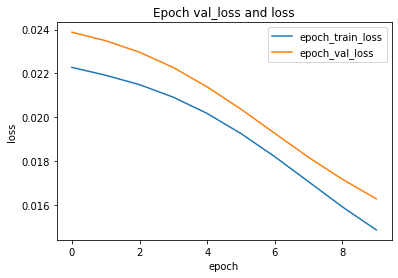

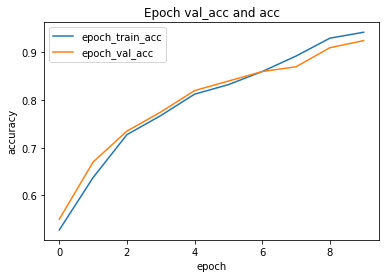



# Trial 15
epoch: 0 | TRAIN: loss 0.02276 acc 0.4825 | VALI: loss 0.02405 acc 0.54
epoch: 1 | TRAIN: loss 0.02213 acc 0.6175 | VALI: loss 0.02375 acc 0.495
epoch: 2 | TRAIN: loss 0.02178 acc 0.52 | VALI: loss 0.02348 acc 0.495
epoch: 3 | TRAIN: loss 0.02148 acc 0.505 | VALI: loss 0.02313 acc 0.71
epoch: 4 | TRAIN: loss 0.02114 acc 0.6975 | VALI: loss 0.02274 acc 0.695
epoch: 5 | TRAIN: loss 0.02078 acc 0.7075 | VALI: loss 0.02236 acc 0.695
epoch: 6 | TRAIN: loss 0.02041 acc 0.715 | VALI: loss 0.02197 acc 0.705
epoch: 7 | TRAIN: loss 0.02003 acc 0.7275 | VALI: loss 0.02159 acc 0.725
epoch: 8 | TRAIN: loss 0.01965 acc 0.7375 | VALI: loss 0.0212 acc 0.73
epoch: 9 | TRAIN: loss 0.01925 acc 0.745 | VALI: loss 0.02079 acc 0.74



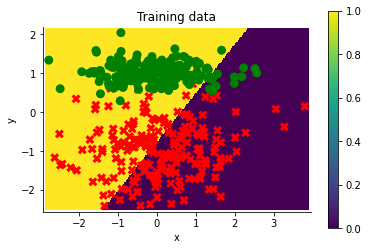

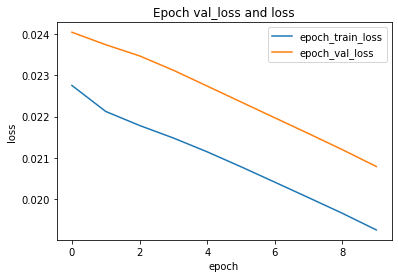

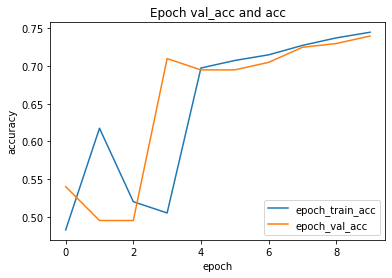



# Trial 16
epoch: 0 | TRAIN: loss 0.02181 acc 0.5075 | VALI: loss 0.02298 acc 0.84
epoch: 1 | TRAIN: loss 0.0207 acc 0.8475 | VALI: loss 0.02212 acc 0.775
epoch: 2 | TRAIN: loss 0.01974 acc 0.8075 | VALI: loss 0.02134 acc 0.745
epoch: 3 | TRAIN: loss 0.0189 acc 0.805 | VALI: loss 0.02062 acc 0.745
epoch: 4 | TRAIN: loss 0.01814 acc 0.8175 | VALI: loss 0.01991 acc 0.77
epoch: 5 | TRAIN: loss 0.01742 acc 0.8425 | VALI: loss 0.0192 acc 0.785
epoch: 6 | TRAIN: loss 0.01672 acc 0.8525 | VALI: loss 0.01847 acc 0.82
epoch: 7 | TRAIN: loss 0.01604 acc 0.875 | VALI: loss 0.01776 acc 0.85
epoch: 8 | TRAIN: loss 0.0154 acc 0.9 | VALI: loss 0.01708 acc 0.855
epoch: 9 | TRAIN: loss 0.01483 acc 0.9075 | VALI: loss 0.01645 acc 0.87



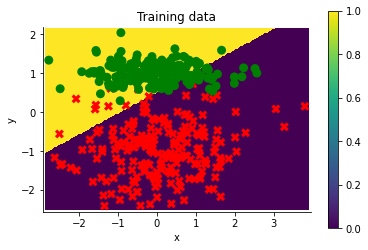

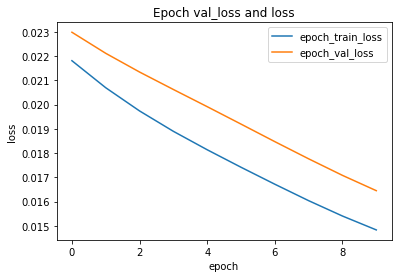

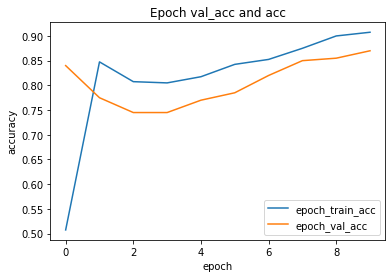



# Trial 17
epoch: 0 | TRAIN: loss 0.0229 acc 0.48 | VALI: loss 0.02427 acc 0.505
epoch: 1 | TRAIN: loss 0.02235 acc 0.5475 | VALI: loss 0.02424 acc 0.51
epoch: 2 | TRAIN: loss 0.0223 acc 0.5625 | VALI: loss 0.02427 acc 0.525
epoch: 3 | TRAIN: loss 0.02226 acc 0.575 | VALI: loss 0.02419 acc 0.535
epoch: 4 | TRAIN: loss 0.02216 acc 0.59 | VALI: loss 0.02408 acc 0.54
epoch: 5 | TRAIN: loss 0.02203 acc 0.5925 | VALI: loss 0.02396 acc 0.535
epoch: 6 | TRAIN: loss 0.02186 acc 0.6 | VALI: loss 0.0238 acc 0.55
epoch: 7 | TRAIN: loss 0.02166 acc 0.6125 | VALI: loss 0.0236 acc 0.575
epoch: 8 | TRAIN: loss 0.02141 acc 0.6225 | VALI: loss 0.02333 acc 0.605
epoch: 9 | TRAIN: loss 0.02111 acc 0.63 | VALI: loss 0.023 acc 0.61



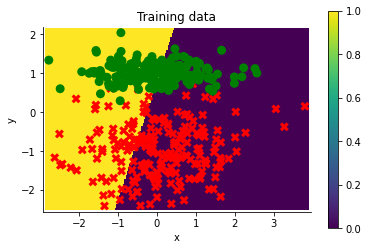

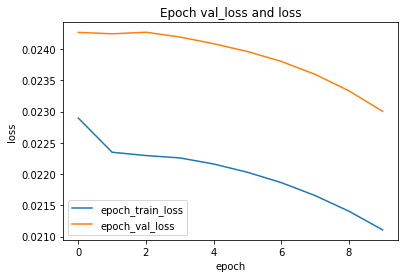

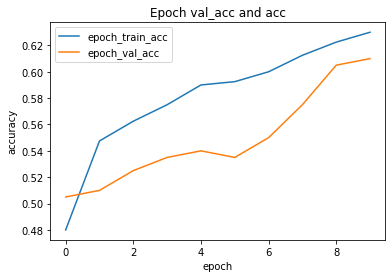



# Trial 18
epoch: 0 | TRAIN: loss 0.0227 acc 0.48 | VALI: loss 0.02426 acc 0.505
epoch: 1 | TRAIN: loss 0.02247 acc 0.53 | VALI: loss 0.02431 acc 0.495
epoch: 2 | TRAIN: loss 0.02247 acc 0.52 | VALI: loss 0.02435 acc 0.495
epoch: 3 | TRAIN: loss 0.02249 acc 0.52 | VALI: loss 0.02435 acc 0.495
epoch: 4 | TRAIN: loss 0.02249 acc 0.52 | VALI: loss 0.02433 acc 0.495
epoch: 5 | TRAIN: loss 0.02248 acc 0.52 | VALI: loss 0.02432 acc 0.495
epoch: 6 | TRAIN: loss 0.02246 acc 0.52 | VALI: loss 0.0243 acc 0.495
epoch: 7 | TRAIN: loss 0.02243 acc 0.52 | VALI: loss 0.02425 acc 0.495
epoch: 8 | TRAIN: loss 0.02235 acc 0.52 | VALI: loss 0.02416 acc 0.495
epoch: 9 | TRAIN: loss 0.02223 acc 0.52 | VALI: loss 0.024 acc 0.495



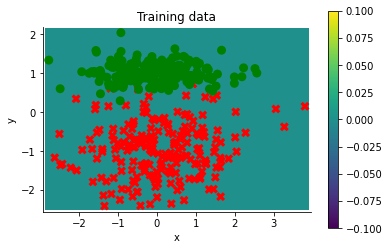

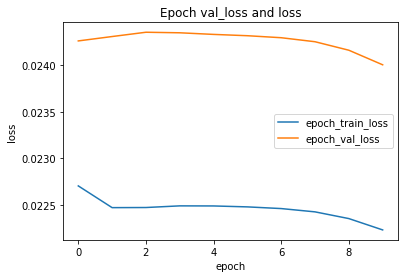

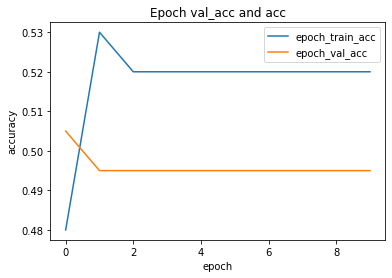



# Trial 19
epoch: 0 | TRAIN: loss 0.02223 acc 0.635 | VALI: loss 0.02373 acc 0.71
epoch: 1 | TRAIN: loss 0.02166 acc 0.75 | VALI: loss 0.02327 acc 0.68
epoch: 2 | TRAIN: loss 0.02108 acc 0.74 | VALI: loss 0.02274 acc 0.695
epoch: 3 | TRAIN: loss 0.02044 acc 0.765 | VALI: loss 0.02211 acc 0.72
epoch: 4 | TRAIN: loss 0.01973 acc 0.79 | VALI: loss 0.0214 acc 0.74
epoch: 5 | TRAIN: loss 0.01897 acc 0.815 | VALI: loss 0.02061 acc 0.775
epoch: 6 | TRAIN: loss 0.01814 acc 0.845 | VALI: loss 0.01974 acc 0.79
epoch: 7 | TRAIN: loss 0.01727 acc 0.8625 | VALI: loss 0.0188 acc 0.845
epoch: 8 | TRAIN: loss 0.01639 acc 0.8975 | VALI: loss 0.01783 acc 0.86
epoch: 9 | TRAIN: loss 0.01553 acc 0.9125 | VALI: loss 0.01692 acc 0.9



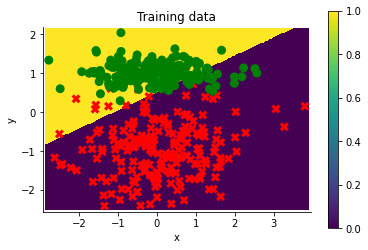

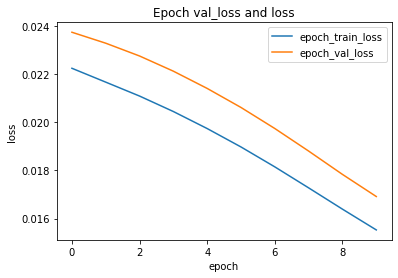

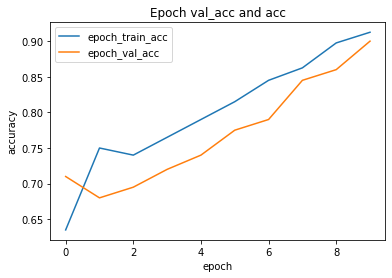


Avg. validation accuracy:0.7081000000000001


In [23]:
layer_dict = archs(2) # implies we have 2 classification classes
layers = layer_dict[5] # using new architecture 

# this will train on dataset "1"
X_train, y_train, model = run_pytorch_2d("3", layers, epochs=10, split=.25, trials = 20, verbose=True, display=True)

## 3C)

Pytorch FC: dataset= 4
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.02041 acc 0.66 | VALI: loss 0.01839 acc 0.92
epoch: 1 | TRAIN: loss 0.01753 acc 0.935 | VALI: loss 0.01628 acc 0.96
epoch: 2 | TRAIN: loss 0.01578 acc 0.945 | VALI: loss 0.01499 acc 0.9625
epoch: 3 | TRAIN: loss 0.01472 acc 0.955 | VALI: loss 0.0142 acc 0.96
epoch: 4 | TRAIN: loss 0.01405 acc 0.96 | VALI: loss 0.01369 acc 0.96
epoch: 5 | TRAIN: loss 0.0136 acc 0.96 | VALI: loss 0.01334 acc 0.9625
epoch: 6 | TRAIN: loss 0.01327 acc 0.9575 | VALI: loss 0.01308 acc 0.96
epoch: 7 | TRAIN: loss 0.01303 acc 0.9575 | VALI: loss 0.01288 acc 0.96
epoch: 8 | TRAIN: loss 0.01283 acc 0.96 | VALI: loss 0.01273 acc 0.96
epoch: 9 | TRAIN: loss 0.01268 acc 0.96 | VALI: loss 0.0126 acc 0.96



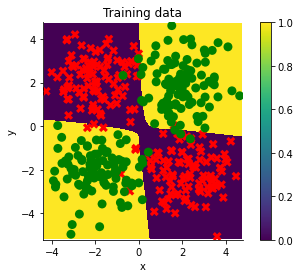

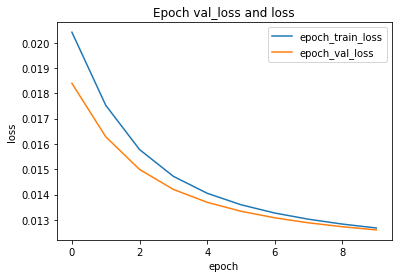

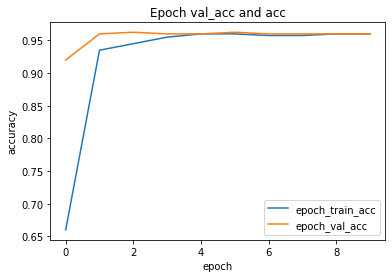


Avg. validation accuracy:0.9565000000000001


In [24]:
layer_dict = archs(2) # implies we have 2 classification classes
layers = layer_dict[2] # using new architecture 

# this will train on dataset "4"
X_train, y_train, model = run_pytorch_2d("4", layers, epochs=10, split=.25, trials = 1, verbose=True, display=True)

## 3D)

In [25]:
# if you don't care about the return values, throw them into a trash variable
for i in range(5):
    _ = run_pytorch_2d("3class",archs(3)[i], epochs = 10, split=.5, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7f91b34847f0>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.3355
Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7f91b3484240>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) c

## 3E)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7f91b332db00>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.03925 acc 0.065 | VALI: loss 0.0389 acc 0.11
epoch: 1 | TRAIN: loss 0.03901 acc 0.07 | VALI: loss 0.03866 acc 0.1225
epoch: 2 | TRAIN: loss 0.03876 acc 0.095 | VALI: loss 0.03841 acc 0.145
epoch: 3 | TRAIN: loss 0.03851 acc 0.1325 | VALI: loss 0.03815 acc 0.1675
epoch: 4 | TRAIN: loss 0.03825 acc 0.1725 | VALI: loss 0.0379 acc 0.1975
epoch: 5 | TRAIN: loss 0.038 acc 0.205 | VALI: loss 0.03764 acc 0.2275
epoch: 6 | TRAIN: loss 0.03774 acc 0.2375 | VALI: loss 0.03738 acc 0.2725
epoch: 7 | TRAIN: loss 0.03749 acc 0.26 | VALI: loss 0.03712 acc 0.29
epoch: 8 | TRAIN: loss

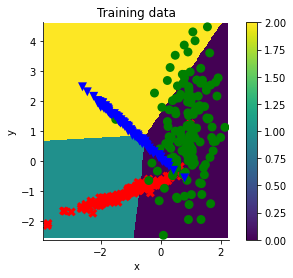

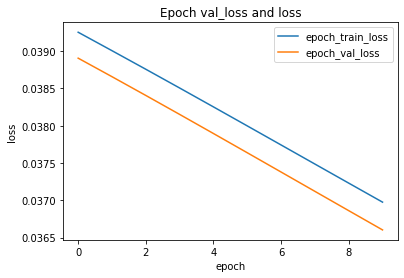

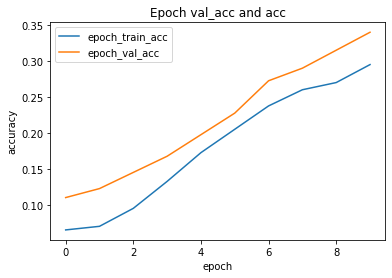


Avg. validation accuracy:0.21875


In [26]:
points = np.array([[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]])

deterministic = True
if deterministic:
  torch.manual_seed(10)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(10)

layer_dict = archs(3) # implies we have 2 classification classes
layers = layer_dict[0] # using architecture 0

X_train, y_train, model = run_pytorch_2d("3class", layers, split=.5, epochs=10, trials = 1, verbose=True, display=True)

In [29]:
model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Softmax(dim=-1)
)

In [33]:
w = model[0].weight.data.numpy()
w

array([[ 0.26732403, -0.08266948],
       [-0.57225597,  0.01566911],
       [-0.6021301 ,  0.5062894 ]], dtype=float32)

In [34]:
w0 = model[0].bias.data.numpy()
w0

array([ 0.44924986, -0.04655844, -0.4772989 ], dtype=float32)

In [39]:
pred = w@points.T+np.array([w0]).T
pred

array([[ 0.18192583,  0.71657389,  1.35861416,  0.36658038,  0.26459531,
         0.09925635,  0.63390441,  0.79924338],
       [ 0.52569753, -0.61881441, -0.21891862, -0.03088933,  0.51002843,
         0.54136664, -0.6031453 , -0.63448351],
       [ 0.12483123, -1.079429  , -6.04648253,  0.02899054, -0.38145819,
         0.63112065, -0.57313958, -1.58571842]])

In [41]:
pred.argmax(axis=0)

array([1, 0, 0, 0, 1, 2, 0, 0])